In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from datetime import datetime
from sklearn.model_selection import train_test_split

In [71]:
exec(open("../../header.py").read())

# Import data

In [35]:
X = pd.read_csv(processed_root('cervical_cancer_risks/X.csv'))
y = pd.read_csv(processed_root('cervical_cancer_risks/y.csv'))['Biopsy']

# Train-validation split

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    train_size = 0.9, test_size = 0.1,
                                                    random_state = 42)

# Functions

In [45]:
def brier_score(y_pred, y_true):
    return np.mean(y_pred - y_val)**2

# Base model

In [39]:
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [46]:
y_pred = rf.predict(X_val)
print(f"Brier score: {brier_score(y_pred, y_val):.5f}")

Brier score: 0.00054


In [88]:
np.mean(y_pred==y_val)

0.9767441860465116

# Tune model

In [89]:
ice = ICE("binary", time = False)

In [90]:
feature = "Age"
max_depths = [i for i in range(1,50,1)]
val_loss = []
val_accuracy = []
rf_fi = []
ice_fi = []
ice_fi_normalized = []

In [91]:
for md in max_depths:
    rf = RandomForestClassifier(max_depth = md, n_estimators = 500)
    rf.fit(X_train, y_train)
    
    # val loss
    y_pred = rf.predict_proba(X_val)[:,1]
    val_loss.append(brier_score(y_pred, y_val))
    
    # val accuracy
    y_pred = rf.predict(X_val)
    val_accuracy.append(np.mean(y_pred == y_val))
    
    # rf feature importance
    rf_fi.append(rf.feature_importances_[X_train.columns == feature].item())
    
    # ice feature impact
    ice.fit_single_feature(X, rf, "Age")
    fis = ice.get_feature_impact("Age")
    ice_fi.append(fis['fi'])
    ice_fi_normalized.append(fis['fi_normalized'])

In [92]:
tune_results = pd.DataFrame({'max_depth':max_depths,
              'brier':val_loss,
              'accuracy':val_accuracy,
              'rf_fi':rf_fi,
              'ice_fi':ice_fi,
              'ice_fi_normalized':ice_fi_normalized})

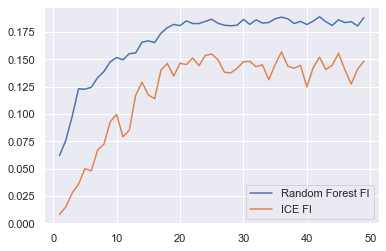

In [93]:
fig, ax = plt.subplots()
ax.plot('max_depth', 'rf_fi', data = tune_results, label = 'Random Forest FI')
ax.plot('max_depth', 'ice_fi_normalized', data = tune_results, label = 'ICE FI')
ax.legend()